# Predicting restaurant ratings from Yelp reviews with NLP and Linear Regression


As part of the Machine Learning course for the Master of Science project in Data Science and Machine Learning at the National Technical University of Athens, we are using the Yelp Academic Dataset to make predictions of user's ratings on restaurants, based on the text of their review. 

The basic analysis steps that we carried out for this project are outlined on this notebook. 

In [1]:
#Load libraries

from sklearn.feature_extraction.text import CountVectorizer,HashingVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV, Ridge, SGDRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn import base
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import dill

## Load and parse the data


In [2]:
#Open the business.csv file with information on businesses found on Yelp

business=pd.read_csv('dataset/business.csv',low_memory=False)

In [3]:
#Keep only restaurants

restaurants=business[(business.categories.str.contains('Restaurants'))  | (business.categories.str.contains('Food'))]
restaurants.shape

(74587, 60)

In [6]:
#Since we need only text, stars and mapping to business, preprocess the chunks for memory efficiency
def review_preprocess(chunk):
    chunk=chunk[['stars','text','business_id']]
    return chunk

In [8]:
chunk_list = []  # append each chunk df here 

# Each chunk is in df format
for chunk in pd.read_csv('dataset/review.csv', chunksize=100000):  
    # perform data filtering 
    chunk_filter = review_preprocess(chunk)
    # Once the data filtering is done, append the chunk to list
    chunk_list.append(chunk_filter)
    
# concat the list into dataframe 
reviews = pd.concat(chunk_list)
reviews

,stars,text,business_id
0,1.0,Total bill for this horrible service? Over $8G...,ujmEBvifdJM6h6RLv4wQIg
1,5.0,I *adore* Travis at the Hard Rock's new Kelly ...,NZnhc2sEQy3RmzKTZnqtwQ
2,5.0,I have to say that this office really has it t...,WTqjgwHlXbSFevF32_DJVw
3,5.0,Went in for a lunch. Steak sandwich was delici...,ikCg8xy5JIg_NGPx-MSIDA
4,1.0,Today was my second out of three sessions I ha...,b1b1eb3uo-w561D0ZfCEiQ
...,...,...,...
6685895,5.0,I have been coming here for years and this pla...,RXBFk3tVBxiTf3uOt9KExQ
6685896,1.0,I think this owner and the owner of Amy's Baki...,yA6dKNm_zl1ucZCnwW8ZCg
6685897,5.0,"Off the grid Mexican in Vegas. Very tasty, qua...",a192hdM0_UVCYLwPJv1Qwg
6685898,5.0,We hired Taco Naco to cater our family party a...,kOo4ZY2UQAX4j312mzQ8mA


In [9]:
rest_reviews = pd.merge(how='left',left=restaurants[['business_id','name']], right=reviews, left_on='business_id', right_on='business_id')


In [10]:
rest_reviews.dropna(inplace=True)

In [11]:
rest_reviews

,business_id,name,stars,text
0,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,3.0,My girlfriend and I went for dinner at Emerald...
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,3.0,We've always been there on a Sunday so we were...
2,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,3.0,"***No automatic doors, not baby friendly!*** I..."
3,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,1.0,"Horrible service,\r\nI went there tonight with..."
4,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,4.0,One of the gauges of a good Chinese restaurant...
...,...,...,...,...
4580296,p1eUTUB_5hf1enoKYBV3DA,Ken Stewart's Tre Belle,5.0,When I write a review on someplace that I have...
4580297,p1eUTUB_5hf1enoKYBV3DA,Ken Stewart's Tre Belle,5.0,We stopped in at Tre Belle on a Tuesday evenin...
4580298,p1eUTUB_5hf1enoKYBV3DA,Ken Stewart's Tre Belle,3.0,I wasnt impressed. The place is beautiful and ...
4580299,p1eUTUB_5hf1enoKYBV3DA,Ken Stewart's Tre Belle,1.0,Last night some friends and I dined at this es...


The dataset has more than 4.5 million reviews on restaurants with their corresponding rating. We will use this dataset to build the model of the analysis

<BarContainer object of 5 artists>

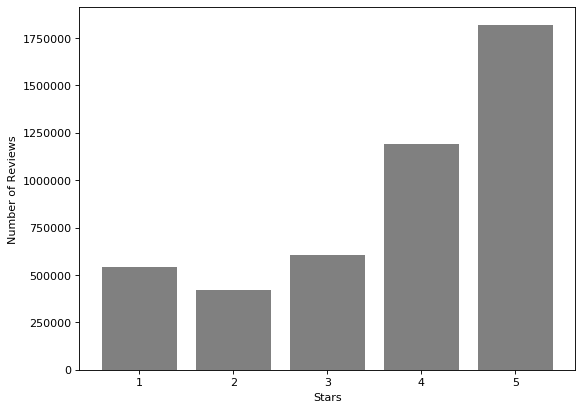

In [12]:
(unique, counts) = np.unique(rest_reviews.stars, return_counts=True)
plt.figure(figsize=(8, 6), dpi=80)
plt.ylabel('Number of Reviews')
plt.xlabel('Stars')

plt.bar(unique, counts,color='grey')

In [12]:
rest_reviews.groupby(['stars']).count()

,business_id,name,text
stars,,,
1.0,544139,544139,544139
2.0,420637,420637,420637
3.0,604359,604359,604359
4.0,1191087,1191087,1191087
5.0,1820077,1820077,1820077


In [13]:
#Keep a smaller and balanced dataset

#50000 reviews for each star

chunk_list = []

for i in range(5):
    chunk_list.append(rest_reviews[rest_reviews.stars==i+1].sample(50000))
    
small_dataset = pd.concat(chunk_list)



In [14]:
small_dataset

,business_id,name,stars,text
3812119,3nDxqHvf7L5AdEAAeMaQAg,Domino's Pizza,1.0,As college students looking for a late night m...
3217020,jsqIJomT833L-BAtm06Cuw,Rosatis Pizza,1.0,My first review ever...\r\nMy first pizza was ...
4246114,d9sv7fexFJiChG9Xl0SP-A,Hot Sauce Williams Barbecue Restaurant,1.0,I wish there was a no star button. After buyin...
2089941,Xk5HlcuuCWv5cQKmI7CjkQ,Goldmans Deli,1.0,"After being a loyal customer for many years, I..."
668941,SIyWuK96ql4m7cFh9ScPMg,Jack in The Box,1.0,This is really a zero star post. When we pulle...
...,...,...,...,...
4551861,Z1mLBp6BMlHSQUh364vk1g,Blue Point Grille,5.0,I'm a big fan of happy hour at BP. There are $...
931736,pxpLVCInGwLClbnwJwxInw,King Tut Cafe & Catering,5.0,Great place to chill. Different style. I use t...
2528949,rkqTVzTkLaWSUybaWUMIdA,Red Robin Gourmet Burgers,5.0,Got here shortly after it opened everyone was ...
1496418,3N9U549Zse8UP-MwKZAjAQ,Liberty Market,5.0,Liberty Market is my favorite place to get bru...


In [21]:
#Do not use 

stars = rest_reviews.stars
text = rest_reviews.text


In [15]:
#Use subset

stars = small_dataset.stars
text = small_dataset.text

In [16]:
text_train, text_test, stars_train, stars_test = train_test_split(text, stars, test_size=0.2)

<BarContainer object of 5 artists>

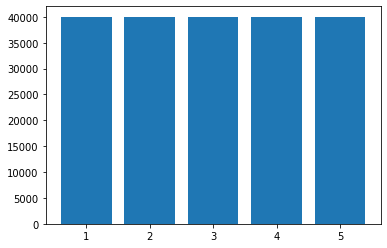

In [19]:
(unique, counts) = np.unique(stars_train, return_counts=True)
plt.bar(unique, counts)

<BarContainer object of 5 artists>

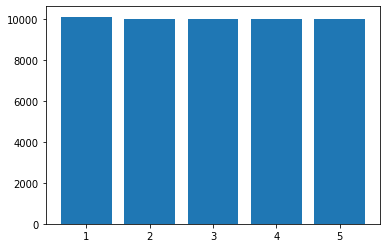

In [20]:
(unique, counts) = np.unique(stars_test, return_counts=True)
plt.bar(unique, counts)

## Building models - Linear Regression with Stochastic Gradient Descent


## bag_of_words_model

First model is predicting the star rating based on the count of the words in each document. In order to use this method, we are using scikit-learn's [`CountVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer) or [`HashingVectorizer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.HashingVectorizer.html#sklearn.feature_extraction.text.HashingVectorizer) (which saves time and memory allocation). After the text is tranformed to an X array of frequencies, we use cross validation to pick the optimal hyperparameters of the regressor. Regressors that are used are Linear, SVM and Random Forest


In [28]:
#not used
X = HashingVectorizer().fit_transform(text)
#X = CountVectorizer().fit_transform(text)

In [30]:
#Grid Search for the Vectorizer

param_grid_bow = {
    'Vec__min_df':[5,10,15],
    'Vec__max_df':[0.4,0.5,0.6]
}

bow_est = Pipeline([
    ('Vec',CountVectorizer()),
    ('SGD',SGDRegressor())
])

gs_bow=GridSearchCV(
    bow_est,param_grid_bow,
    cv=5, 
    scoring='neg_mean_squared_error'
)


gs_bow.fit(text, stars) 

gs_bow.best_estimator_


Pipeline(steps=[('Vec', CountVectorizer(max_df=0.6, min_df=10)),
                ('SGD', SGDRegressor())])

In [32]:
#Grid Search for  Regression (using stochastic gradient descent)

#Use count vectorizer values from previous step

X = CountVectorizer(min_df=10,max_df=0.6).fit_transform(text)

param_grid_bow = {
    #,
    'SGD__penalty':['l1','l2'],
    'SGD__alpha': [0.005,0.01,0.05]
}

bow_est = Pipeline([
    ('SGD',SGDRegressor())
])



gs_bow=GridSearchCV(
    bow_est,param_grid_bow,
    cv=5, 
    scoring='neg_mean_squared_error'
)


gs_bow.fit(X, stars) 

gs_bow.best_estimator_


Pipeline(steps=[('SGD', SGDRegressor(alpha=0.01))])

In [33]:
list(ParameterGrid(param_grid_bow))[gs_bow.best_index_]

{'SGD__alpha': 0.01, 'SGD__penalty': 'l2'}

In [35]:
#Use final values for model

bag_of_words_est = Pipeline([
    ('Vec',CountVectorizer(min_df=10,max_df=0.6)),
    ('SGD',SGDRegressor(alpha=0.01,penalty='l2'))
])

bag_of_words_est.fit(text_train,stars_train)

Pipeline(steps=[('Vec', CountVectorizer(max_df=0.6, min_df=10)),
                ('SGD', SGDRegressor(alpha=0.01))])

In [36]:
pred=bag_of_words_est.predict(text_test)

In [42]:
pred_stars = np.round(pred)

In [43]:
metrics.mean_squared_error(stars_test,pred)

0.932363013245037

In [55]:
metrics.mean_squared_error(stars_test,pred_stars)

1.03028

In [44]:
metrics.r2_score(stars_test,pred)

0.5349387611653098

In [46]:
metrics.accuracy_score(stars_test,pred_stars)

0.36798

## normalized_model with TF-IDF

Normalization is key for good linear regression. Previously, we used the count as the normalization scheme.  Now we add a normalization with TF-IDF.

[TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) is a common normalization scheme used in text processing.  We Use the [`TfidfTransformer`](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html#sklearn.feature_extraction.text.TfidfTransformer). There are options for using `idf` and taking the logarithm of `tf`.  

In [49]:
#Grid Search without the Vectorizer - using tf-idf

V = CountVectorizer(min_df=10,max_df=0.6).fit_transform(text)
X = TfidfTransformer().fit_transform(V)

param_grid_norm ={
    'SGD__alpha': [0.002,0.01,0.015,0.05],
    'SGD__penalty':['l1','l2']
}

norm_est = Pipeline([
    ('SGD',SGDRegressor())
])

gs_norm=GridSearchCV(
    norm_est,param_grid_norm,
    cv=5, 
    scoring='neg_mean_squared_error'
)


gs_norm.fit(X, stars) #X or text depending if we are grid searching on the vectorizer

gs_norm.best_estimator_


Pipeline(steps=[('SGD', SGDRegressor(alpha=0.002))])

In [50]:
list(ParameterGrid(param_grid_norm))[gs_norm.best_index_]

{'SGD__alpha': 0.002, 'SGD__penalty': 'l2'}

In [52]:
#Use final values 

unigram_norm_est = Pipeline([
    ('Vec',CountVectorizer(min_df=10,max_df=0.6)),
    ('tfidf',TfidfTransformer()),
    ('SGD',SGDRegressor(alpha=0.002,penalty='l2'))
])

unigram_norm_est.fit(text_train,stars_train)

Pipeline(steps=[('Vec', CountVectorizer(max_df=0.6, min_df=10)),
                ('tfidf', TfidfTransformer()),
                ('SGD', SGDRegressor(alpha=0.002))])

In [53]:
pred=unigram_norm_est.predict(text_test)
metrics.mean_squared_error(stars_test,pred)

0.9461971873272936

In [54]:
metrics.r2_score(stars_test,pred)

0.5280382963832966

## bigram_model

In a bigram model, we'll consider both single words and pairs of consecutive words that appear.  This is going to be a much higher dimensional problem (large $p$) so we should be careful about overfitting. To avoid memory issues we are using the HashingVectorizer instead of the CountVectorizer


In [63]:
#Grid Search for the Vectorizer

param_grid_bi = {
    'Vec__min_df':[6,8,10],
    'Vec__max_df':[0.5, 0.6]
}

bi_est = Pipeline([
    ('Vec',CountVectorizer(ngram_range=(1,2))),
    ('SGD',SGDRegressor())
])

gs_bi=GridSearchCV(
    bi_est,param_grid_bi,
    cv=3, 
    scoring='neg_mean_squared_error'
)


gs_bi.fit(text, stars) 

gs_bi.best_estimator_


Pipeline(steps=[('Vec',
                 CountVectorizer(max_df=0.6, min_df=10, ngram_range=(1, 2))),
                ('SGD', SGDRegressor())])

In [57]:
#Grid Search for SGD

#X = HashingVectorizer(ngram_range=(1,2)).fit_transform(text)

X = CountVectorizer(ngram_range=(1,2),min_df=10,max_df=0.6).fit_transform(text)

param_grid_bi = {
    'SGD__alpha': [0.001,0.005,0.01,0.05],
    'SGD__penalty':['l1','l2']
}

bi_est = Pipeline([
    ('SGD',SGDRegressor())
])

gs_bi=GridSearchCV(
    bi_est,param_grid_bi,
    cv=5, 
    scoring='neg_mean_squared_error'
)


gs_bi.fit(X, stars) #X or text depending if we are grid searching on the vectorizer

gs_bi.best_estimator_

Pipeline(steps=[('SGD', SGDRegressor(alpha=0.005))])

In [58]:
list(ParameterGrid(param_grid_bi))[gs_bi.best_index_]

{'SGD__alpha': 0.005, 'SGD__penalty': 'l2'}

In [67]:
#Use final values 


bigram_est = Pipeline([
    ('Vec',CountVectorizer(ngram_range=(1,2),min_df=10,max_df=0.6)),
    #('Vec',HashingVectorizer(norm=None,ngram_range=(1,2))),
    ('SGD',SGDRegressor(alpha=0.005, penalty='l2'))
])

bigram_est.fit(text_train,stars_train)

Pipeline(steps=[('Vec',
                 CountVectorizer(max_df=0.6, min_df=10, ngram_range=(1, 2))),
                ('SGD', SGDRegressor(alpha=0.005))])

In [68]:
pred=bigram_est.predict(text_test)
metrics.mean_squared_error(stars_test,pred)

0.8132429756084537

In [69]:
metrics.r2_score(stars_test,pred)

0.5943556529620944

## Bigram model with TFIDF

In [86]:
#Grid Search for the Vectorizer

param_grid_bi_norm = {
    'Vec__min_df':[6,8,10],
    'Vec__max_df':[0.5, 0.6]
}

bi_norm_est = Pipeline([
    ('Vec',CountVectorizer(ngram_range=(1,2))),
    ('tran',TfidfTransformer()),
    ('SGD',SGDRegressor())
])

gs_bi_norm=GridSearchCV(
    bi_norm_est,param_grid_bi_norm,
    cv=3, 
    scoring='neg_mean_squared_error'
)


gs_bi_norm.fit(text, stars) 

gs_bi_norm.best_estimator_

Pipeline(steps=[('Vec',
                 CountVectorizer(max_df=0.6, min_df=10, ngram_range=(1, 2))),
                ('tran', TfidfTransformer()), ('SGD', SGDRegressor())])

In [84]:
#Grid Search for SGD
V = CountVectorizer(ngram_range=(1,2),min_df=10,max_df=0.6).fit_transform(text)
#V = HashingVectorizer(norm=None,ngram_range=(1,2)).fit_transform(text)
X = TfidfTransformer().fit_transform(V)

param_grid_bi_norm = {
    'SGD__alpha': [0.0003,0.0005],
}

bi_norm_est = Pipeline([
    ('SGD',SGDRegressor())
])

gs_bi_norm=GridSearchCV(
    bi_norm_est,param_grid_bi_norm,
    cv=5, 
    scoring='neg_mean_squared_error'
)


gs_bi_norm.fit(X, stars) #X or stars depending if we are grid searching on the vectorizer

gs_bi_norm.best_estimator_

Pipeline(steps=[('SGD', SGDRegressor(alpha=0.0005))])

In [90]:
#Use final values 


bigram_norm_est = Pipeline([
      ('Vec',CountVectorizer(ngram_range=(1,2),min_df=10,max_df=0.6)),
    #('Vec',HashingVectorizer(norm=None,ngram_range=(1,2))),
     ('tfidf',TfidfTransformer()),
    ('SGD',SGDRegressor(alpha=0.0003,penalty='l2'))
])

bigram_norm_est.fit(text_train,stars_train)

Pipeline(steps=[('Vec',
                 CountVectorizer(max_df=0.6, min_df=10, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('SGD', SGDRegressor(alpha=0.0003))])

In [91]:
pred=bigram_norm_est.predict(text_test)
metrics.mean_squared_error(stars_test,pred)

0.7561160298520776

In [92]:
metrics.r2_score(stars_test,pred)

0.622850485754566